## REACT AGENT

##### Load the environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [ ]:
from langchain_aws import ChatBedrock
llm = ChatBedrock(model=model_id)

##### Memory

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

##### Tools

In [ ]:
import boto3
from langchain_core.tools import tool

@tool
def retriever_tool(query):
    """Query the knowledge base for information related to Agents and Agentic workflow
    
    Args:
        query: The query string to search for
    """
    bedrock_agent = boto3.client('bedrock-agent-runtime', region_name = aws_region)
    print("QUERYING KB")


    response = bedrock_agent.retrieve_and_generate(
        input={
            "text": query  # Your query text goes here
        },
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                "knowledgeBaseId": bedrock_kb_id,
                "modelArn": model_id,
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults": 5
                    }
                }
            }
        }
    )

    kb_results = response['output']['text']
    return kb_results

In [15]:
@tool
def blogger_tool(context):
    """Ue this tool to write a well formatted blog with a blog title
    
    Args:
        context: The context for the blog
    """
    print("WRITING BLOG")
    prompt = f""" Your job is to create a blog title and a one paragraph blog from this content: {context}"""

    final_answer = llm.invoke(prompt)           
    return final_answer

In [16]:
@tool
def translate_tool(context, language):
    """Ue this tool to translate the content from english to any other language
    
    Args:
        context: The context to be translated
        language: The language to translate to
    """
    print("BLOG TRANSLATION")
    prompt = f""" Your job is to translate the context in {context} from english to {language} """

    final_answer = llm.invoke(prompt)           
    return final_answer

In [17]:
tools = [retriever_tool, blogger_tool, translate_tool]

##### Response Formatters

In [18]:
from pydantic import BaseModel, Field

class FormattedResponse(BaseModel):
    """Respond to the user in this format."""
    Blog_Title: str = Field(description="title of the blog")
    Blog_Content: str = Field(description="content of the blog")
    Blog_language: str = Field(description="language of the blog")

##### Build the agent

In [19]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    llm, tools=tools, 
    checkpointer=memory,
    response_format=FormattedResponse,
)

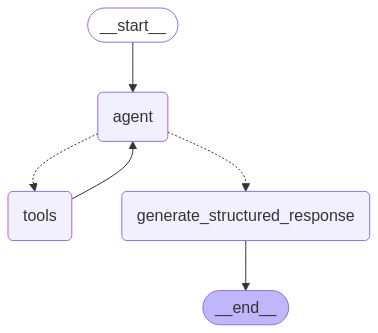

In [20]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

##### Stream the response

In [21]:
def print_stream(stream):
    """A utility to pretty print the stream."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [22]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "42"}}

inputs = {"messages": [("user", "what a blog about the types of agents")]}
print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

what a blog about the types of agents
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (toolu_bdrk_01GfjWuQLebWppSaGgV5ma8M)
 Call ID: toolu_bdrk_01GfjWuQLebWppSaGgV5ma8M
  Args:
    query: types of agents and their characteristics
QUERYING KB
================================= Tool Message =================================
Name: retriever_tool

The search results do not provide specific information about different types of agents and their characteristics. The results primarily focus on memory systems for Large Language Model (LLM) agents and do not contain a comprehensive list or description of various agent types. However, the results do mention LLM agents, which are described as extending the capabilities of large language models by enabling interactive decision-making and executing complex workflows through structured interaction patterns. W